# Control of Aggregate Equilibrium Size

Reference https://ac-els-cdn-com.ezproxy.neu.edu/S092777571300558X/1-s2.0-S092777571300558X-main.pdf?_tid=a68d75de-2d4b-4e84-858f-c3866c0dcf14&acdnat=1542312142_f822cc2a074bc4ea24c4df9fcae90672 for the initial part of the project.

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import math

In [92]:
#set up the bins
L = np.linspace(0,20,101)
size_step = np.diff(L)

In [93]:
#the initial distribution is arbitrary
def initial(L):
    density = 0.4*np.exp(-(L-5)**2/5)
    return density

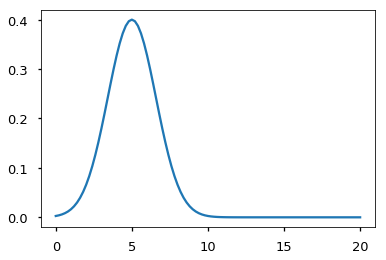

(1.5840900787422294, 2.771846964117317e-10)

In [94]:
plt.plot(L, initial(L))
plt.show()

#integral should be close to 1
integrate.quad(initial, 0, 20)

In [95]:
space_under_curve = integrate.quad(initial, 0, 20)[0]
for l in L:
    if (integrate.quad(initial, 0, l)[0] >= 0.5*space_under_curve):
        avg_size = l
        break
avg_size
#average size in um

5.2

**Assume there is no growth or brakage and only aggregation for now. (Eq. 2)**

$$\frac{\Delta n}{\Delta t} = B - D$$

**To calculate the aggregation frequency, use the following equation. (Eq. 3)**

$$\beta_{j,k} = \frac{2k_BT}{3{\mu}W_{j,k}}(r_j+r_k)(\frac{1}{r_j}+\frac{1}{r_k}) $$

Where the stability ratio $$ W_{j,k} = (r_j+r_k)\int_{r_j+r_k}^{\infty} \frac{exp(V_T/(k_bT))}{R^2} dR $$

$$ V_T = V_A + V_E $$

$$ V_A = -\frac{A}{6}(\frac{2r_1r_2}{R^2-(r_1+r_2)^2}+\frac{2r_1r_2}{R^2(r_1-r_2)^2}+\frac{R^2-(r_1+r_2)^2}{R^2-(r_1-r_2)^2}) $$

$$ V_E = 64\pi\epsilon_r\epsilon_0(\frac{k_BT}{z_ce})^2 tanh(\frac{z_ce\psi_{01}}{4k_BT})tanh(\frac{z_ce\psi_{02}}{4k_BT})(\frac{r_1r_2}{r_1+r_2})exp(-\kappa(R-r_1-r_2)) $$

The value of the debye-huckel parameter comes from Russel, W.B., Saville, D.A. and Schowalter, W. R. Colloidal Dispersions, Cambridge University Press, 1989


$$ \kappa = \sqrt{\frac{2000e^2N I}{\epsilon_r \epsilon_0 k T}} $$

Where the ionic strength is the weighted sum of valence of the ions in solution. $$ I = \frac{1}{2}\sum_j m_j z_j^2 $$

But this should simplify because we only have one ion in solution and we can solve for the molality and we already have the valence of the counterion.

In [96]:
#some constants, from paper
kB = 1.3806 * 10**(-23) #m^2 * kg / (s^2 * K)
A = 3.08 * 10**(-20) #J
psi = 59./1000 #mV #surface potential (UNITS???)
T = 300. #K, im assuming this cuz its not given
mu = 0.00086 #N * s / m^2, from engineering toolbox cuz its not given
er = 80.4 #dielectric constant of solvent (water)
e0 = 8.85*10**-12 #dielectric constant of vacuum (F/m) eng'g toolbox
zc = 1. #valence of potassium counterion
e = 1.6021766*10**-19 # elementary charge (C)
N = 6.022*10**23 #Avogadros Number
rho = 1.*10**3 #kg/m^3 

In [97]:
#solve for the Debye-Huckel Parameter
#it depends on the molality of salt ions in solution

#ONLY VALID AT 0.29 M SALT

M = 0.29 #mol/L
m = M*1000/(rho)
I = (m*zc**2)/2
#kappa = (8*(math.pi**2)*N*rho*I/(1000*er*kB*T))**.5 old value, gave value on order of 10^20
kappa = (er * e0 * kB * T / (2 * 1000 * N *e**2 * I))**0.5
print("The value for the Debye-Huckel Parameter is {}".format(kappa))
#debye huckel only value for low concentration electrolytes, which this isnt

The value for the Debye-Huckel Parameter is 8.108013489212379e-10


In [98]:
#attractive potential
def Va(R, r1, r2):
    Va =-A/6*(2*r1*r2/(R**2-(r1+r2)**2)+2*r1*r2/(R**2*(r1-r2)**2)+(R**2-(r1 + r2)**2)/(R**2-(r1-r2)**2))
    return Va

#repulsive potential
def Ve(R, r1,r2):
    Ve=64*math.pi*er*e0*(kB*T/(zc*e))**2*(np.tanh(zc*e*psi/(4. * kB * T)))**2*r1*r2/(r1+r2)*np.exp(-kappa*(R-r1-r2))
    return Ve

#total potential
def VT(R, r1,r2):
    VT = Ve(R) +Va(R)
    return VT

#integrand to solve for the stability ratio
def W(R, r1,r2):
    W = (r1+r2) * np.exp(VT(R)/(kB*T))/(R**2)
    return W

## Brownian Type Aggregation Kernel

In [99]:
#aggregation frequency / growth kernel
#takes in r1 and r2 and outputs aggregation frequency
def Beta(r1, r2):
    #eqn 3 (Brownian aggregation), 4 (aggregation efficiency),
    # and 5 and 6 (interaction potential components)
    # the equations use both j,k and 1,2 should we just use one consistently?
    r1=r1 /10**6
    r2=r2 / 10**6
    if(r1==0):
        r1 = 0.00001
    if(r2==0):
        r2 = 0.00001
    
    #center-to-center distance when the particles are in contact
    R0 = r1+r2
    
    #solve for the stability ratio
    #we have to integrate over the range in possible center-to-center distances
    
    #assume all collisons result in aggregation
    #Wjk = integrate.quad(W, R0, 1000.)
    Wjk = 0.00000000001
    
    # in eqn theres two tanh for the two colliding paticles but if theyre the same they have the same surface potential
    #solve for the aggregation frequency
    #calculate the combinations of two particles that can lead to an aggregate of size R0
 
    beta = 2 * kB * T / (3 * mu * Wjk) * (r1 + r2) * (1/r1 + 1/r2)
    return beta

In [100]:
Beta(0.7,1.3)

1.411295681063123e-06

## Birthrate and Deathrate

In [101]:
#all possible combinations
beta_matrix = np.zeros((len(L),len(L)))
for indexi, i in enumerate(L):
    for indexj, j in enumerate(L):
        if(j < i):
            beta_matrix[indexi,indexj] = Beta(i,j)
        else:
            break
print(beta_matrix.shape)
#beta_matrix

(101, 101)


In [102]:
#birth rate
n = initial(L)

#takes in a particle size and a distribution
def birthrate(particle_size, n):
    for i in enumerate(L):
        size = i[1]
        if (size==particle_size):
            indexL = i[0]
            break
            
    subL = L[1:indexL:1]
    
    birth = 0
    indexi = 0
    for i in subL:
        indexj = 0
        for j in subL:
            if (i**3+j**3 <= L[indexL]**3 and i**3+j**3 > L[indexL-1]**3):
                birth += Beta(i,j)*n[indexi]*n[indexj]
            indexj += 1
        indexi += 1
        
    return birth

In [103]:
print(birthrate(4, n))

4.722517461012547e-07


In [104]:
#death rate
def deathrate(particle_size, n):
    for i in enumerate(L):
        size = i[1]
        if (size==particle_size):
            indexj = i[0]
            break
            
    j = particle_size
    death = 0
    indexi = 0
    for i in L:
        death += Beta(i,j)*n[indexi]*n[indexj]
        indexi += 1
        
    return death

In [105]:
print(deathrate(4, n))

3.483900969919321e-06


## Calculate the Rate of Change

In [106]:
#solve different equation for each bin in L
#ref in class example for first order finite difference
def rates_of_change(n, t, L, end_time=0):
    size_step = np.diff(L)
    
    #rates of transition
    rates_of_transition = np.zeros_like(n)
    for i in range(len(rates_of_transition)):
        rates_of_transition[i] = n[i] * (birthrate(L[i],n) - deathrate(L[i],n))/size_step[0]
        
    #conservation of particle mass, in this case volume with constant density
        
    #monitor ode solver
    print("running at time {}/{} seconds...".format(t,end_time))
    
    return rates_of_transition

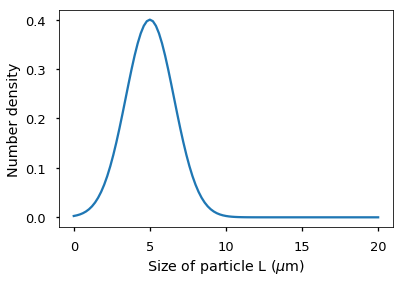

running at time 0/0 seconds...


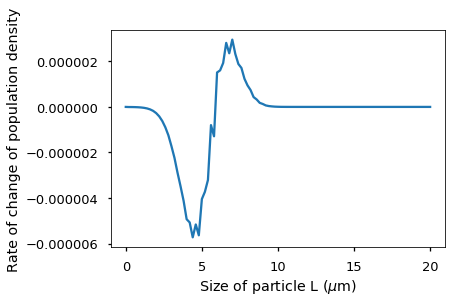

In [107]:
#at time zero what does it look like?
n = initial(L)
t= 0
plt.plot(L, initial(L))
plt.ylabel('Number density')
plt.xlabel('Size of particle L ($\mu$m)')
plt.show()

plt.plot(L,rates_of_change(n, t, L))
plt.ylabel('Rate of change of population density')
plt.xlabel('Size of particle L ($\mu$m)')
plt.show()

## Solve Set of Diff Eqs

In [113]:
T = 300
times = np.arange(0,204000,4000)
times

array([     0,   4000,   8000,  12000,  16000,  20000,  24000,  28000,
        32000,  36000,  40000,  44000,  48000,  52000,  56000,  60000,
        64000,  68000,  72000,  76000,  80000,  84000,  88000,  92000,
        96000, 100000, 104000, 108000, 112000, 116000, 120000, 124000,
       128000, 132000, 136000, 140000, 144000, 148000, 152000, 156000,
       160000, 164000, 168000, 172000, 176000, 180000, 184000, 188000,
       192000, 196000, 200000])

running at time 0.0/200000 seconds...
running at time 0.48821385660432026/200000 seconds...
running at time 0.48821385660432026/200000 seconds...
running at time 0.9764277132086405/200000 seconds...
running at time 0.9764277132086405/200000 seconds...
running at time 201.39530010744681/200000 seconds...
running at time 201.39530010744681/200000 seconds...
running at time 401.814172501685/200000 seconds...
running at time 401.814172501685/200000 seconds...
running at time 602.2330448959232/200000 seconds...
running at time 602.2330448959232/200000 seconds...
running at time 1229.8001577231755/200000 seconds...
running at time 1229.8001577231755/200000 seconds...
running at time 1857.3672705504277/200000 seconds...
running at time 1857.3672705504277/200000 seconds...
running at time 1739.397320783474/200000 seconds...
running at time 1739.397320783474/200000 seconds...
running at time 2248.9944838437727/200000 seconds...
running at time 2248.9944838437727/200000 seconds...
running at tim

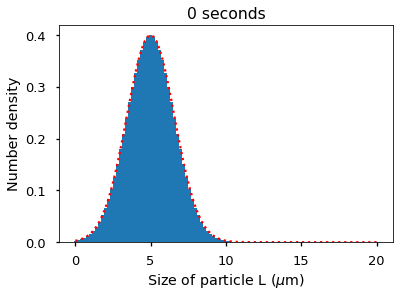

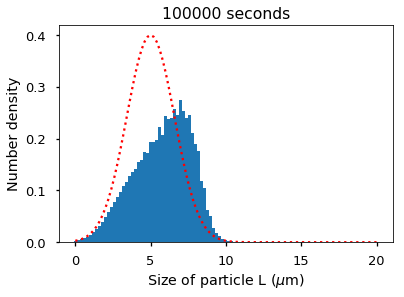

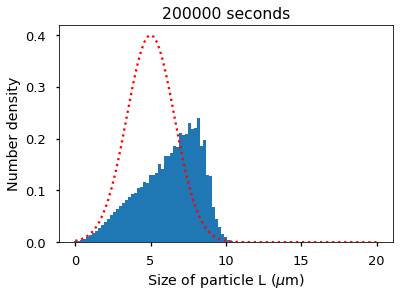

5min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [114]:
%%timeit -n1 -r1
results = integrate.odeint(rates_of_change, initial(L), times, args=(L,times[-1]))

size_step = np.diff(L)
for time, result in zip(times, results):
    if (time%100000 == 0):
        plt.plot(L, initial(L), 'r:')
        plt.bar(L, result, width=size_step[0])
        plt.title("{} seconds".format(time))
        plt.ylabel('Number density')
        plt.xlabel('Size of particle L ($\mu$m)')
        plt.show()

## Sensitivity Analysis

We use the Morris Method for sensitivity analysis in this work due to time considerations.

In [109]:
#different Temperature
T = 400

In [110]:
times = np.arange(0,204000,4000)
times

array([     0,   4000,   8000,  12000,  16000,  20000,  24000,  28000,
        32000,  36000,  40000,  44000,  48000,  52000,  56000,  60000,
        64000,  68000,  72000,  76000,  80000,  84000,  88000,  92000,
        96000, 100000, 104000, 108000, 112000, 116000, 120000, 124000,
       128000, 132000, 136000, 140000, 144000, 148000, 152000, 156000,
       160000, 164000, 168000, 172000, 176000, 180000, 184000, 188000,
       192000, 196000, 200000])

running at time 0.0/200000 seconds...
running at time 0.48816096466176584/200000 seconds...
running at time 0.48816096466176584/200000 seconds...
running at time 0.9763219293235317/200000 seconds...
running at time 0.9763219293235317/200000 seconds...
running at time 151.3133368555615/200000 seconds...
running at time 151.3133368555615/200000 seconds...
running at time 301.6503517817995/200000 seconds...
running at time 301.6503517817995/200000 seconds...
running at time 451.9873667080375/200000 seconds...
running at time 451.9873667080375/200000 seconds...
running at time 922.666706525226/200000 seconds...
running at time 922.666706525226/200000 seconds...
running at time 1393.3460463424144/200000 seconds...
running at time 1393.3460463424144/200000 seconds...
running at time 1304.8569634504163/200000 seconds...
running at time 1304.8569634504163/200000 seconds...
running at time 1687.0472203756067/200000 seconds...
running at time 1687.0472203756067/200000 seconds...
running at time 

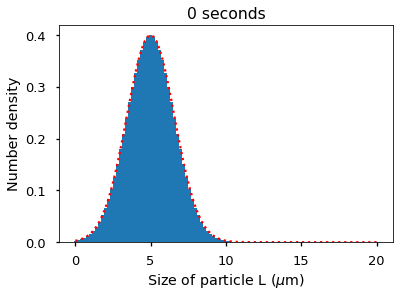

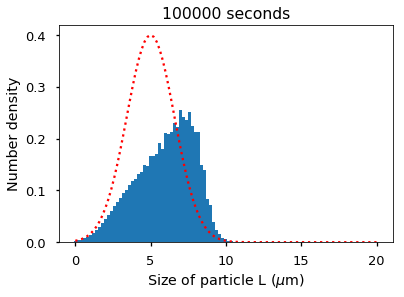

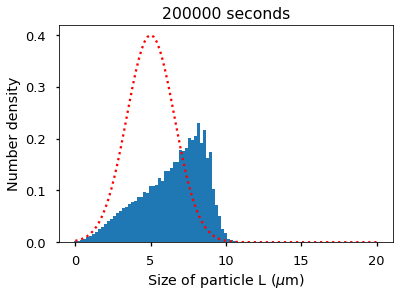

4min 32s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [111]:
%%timeit -n1 -r1
results = integrate.odeint(rates_of_change, initial(L), times, args=(L,times[-1]))

size_step = np.diff(L)
for time, result in zip(times, results):
    if (time%100000 == 0):
        plt.plot(L, initial(L), 'r:')
        plt.bar(L, result, width=size_step[0])
        plt.title("{} seconds".format(time))
        plt.ylabel('Number density')
        plt.xlabel('Size of particle L ($\mu$m)')
        plt.show()

In [115]:
#different viscosity
T = 300
mu = 0.01

running at time 0.0/200000 seconds...
running at time 0.4882813825512665/200000 seconds...
running at time 0.4882813825512665/200000 seconds...
running at time 0.976562765102533/200000 seconds...
running at time 0.976562765102533/200000 seconds...
running at time 2317.410621893713/200000 seconds...
running at time 2317.410621893713/200000 seconds...
running at time 4633.844681022323/200000 seconds...
running at time 4633.844681022323/200000 seconds...
running at time 6950.278740150934/200000 seconds...
running at time 6950.278740150934/200000 seconds...
running at time 14247.11736565366/200000 seconds...
running at time 14247.11736565366/200000 seconds...
running at time 21543.955991156385/200000 seconds...
running at time 21543.955991156385/200000 seconds...
running at time 20179.356152846856/200000 seconds...
running at time 20179.356152846856/200000 seconds...
running at time 26111.594940040053/200000 seconds...
running at time 26111.594940040053/200000 seconds...
running at time 32

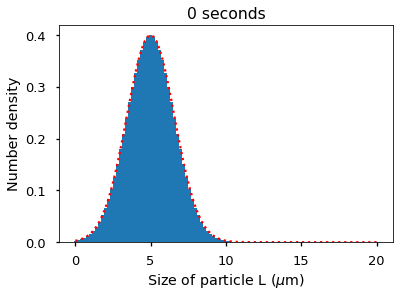

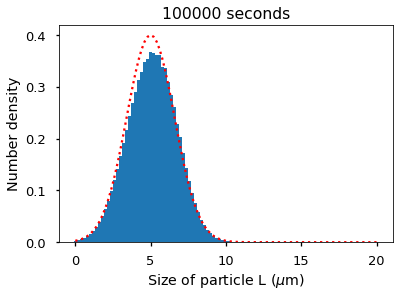

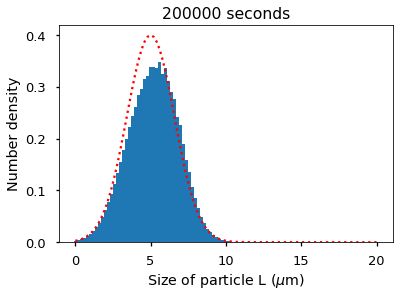

1min 40s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [116]:
%%timeit -n1 -r1
results = integrate.odeint(rates_of_change, initial(L), times, args=(L,times[-1]))

size_step = np.diff(L)
for time, result in zip(times, results):
    if (time%100000 == 0):
        plt.plot(L, initial(L), 'r:')
        plt.bar(L, result, width=size_step[0])
        plt.title("{} seconds".format(time))
        plt.ylabel('Number density')
        plt.xlabel('Size of particle L ($\mu$m)')
        plt.show()

In [117]:
#different dielectric constant
T = 300
mu = 0.00086
er = 100

running at time 0.0/200000 seconds...
running at time 0.48821385660432026/200000 seconds...
running at time 0.48821385660432026/200000 seconds...
running at time 0.9764277132086405/200000 seconds...
running at time 0.9764277132086405/200000 seconds...
running at time 201.39530010744681/200000 seconds...
running at time 201.39530010744681/200000 seconds...
running at time 401.814172501685/200000 seconds...
running at time 401.814172501685/200000 seconds...
running at time 602.2330448959232/200000 seconds...
running at time 602.2330448959232/200000 seconds...
running at time 1229.8001577231755/200000 seconds...
running at time 1229.8001577231755/200000 seconds...
running at time 1857.3672705504277/200000 seconds...
running at time 1857.3672705504277/200000 seconds...
running at time 1739.397320783474/200000 seconds...
running at time 1739.397320783474/200000 seconds...
running at time 2248.9944838437727/200000 seconds...
running at time 2248.9944838437727/200000 seconds...
running at tim

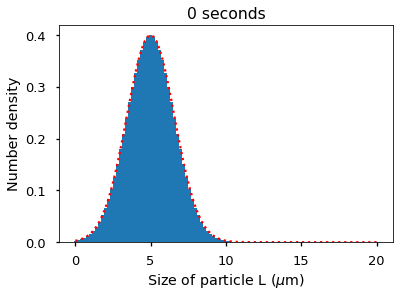

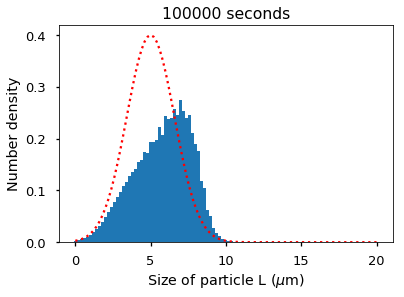

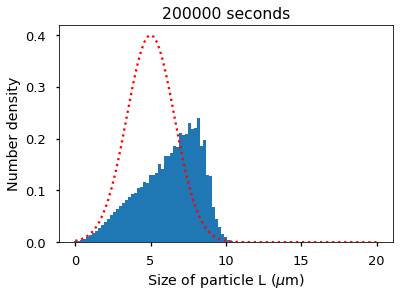

5min 3s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [118]:
%%timeit -n1 -r1
results = integrate.odeint(rates_of_change, initial(L), times, args=(L,times[-1]))

size_step = np.diff(L)
for time, result in zip(times, results):
    if (time%100000 == 0):
        plt.plot(L, initial(L), 'r:')
        plt.bar(L, result, width=size_step[0])
        plt.title("{} seconds".format(time))
        plt.ylabel('Number density')
        plt.xlabel('Size of particle L ($\mu$m)')
        plt.show()

In [38]:
from ipywidgets import widgets, interact
from IPython.display import display
%matplotlib inline
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
figsize(12, 10)
sbn.set_context("talk", font_scale=1)

In [39]:
import SALib
SALib.__version__

from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp

In [72]:
"""
We want to optimize an electrocoagulation system to minimize cost
to operate.

However, without being able to incorporate DLVO theory, we cannot 
determine the behavior of the system in response to a change in
ionic content. Therefore, we cannot determine the power supply 
requirement to dose in metal ions.
"""
def cost_to_operate():
    raise NotImplementedError("cannot be done with available info")

In [41]:
#the morris problem is described by a python dictionary
morris_problem = {
    #number of variables
    'num_vars': 4,
    #variable names
    'names': ['surface_potential', 'temperature', 'viscosity', 'dielectric_constant'],
    #range in those variables
    'bounds': [[0.02,0.1],
               [300,400],
               [0.00086,0.01],
               [50,100]],
    #not grouping any variables together
    'groups': None
}

In [42]:
%%timeit -n1 -r1

#create a sample
num_levels = 4
grid_jump = 2
tranjectories = int(1e4)
sample = ms.sample(morris_problem, tranjectories, num_levels, grid_jump)
print(sample.shape)

(50000, 4)
4.46 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [54]:
#factor prioritization
print(sample.T)
print(sample.T.shape)

[[4.66666667e-02 1.00000000e-01 1.00000000e-01 ... 4.66666667e-02
  1.00000000e-01 1.00000000e-01]
 [3.66666667e+02 3.66666667e+02 3.66666667e+02 ... 4.00000000e+02
  4.00000000e+02 4.00000000e+02]
 [8.60000000e-04 8.60000000e-04 6.95333333e-03 ... 8.60000000e-04
  8.60000000e-04 6.95333333e-03]
 [1.00000000e+02 1.00000000e+02 1.00000000e+02 ... 1.00000000e+02
  1.00000000e+02 1.00000000e+02]]
(4, 50000)


In [89]:
#encapsulate the model
def PBE(surface_potential, temperature, viscosity, dielectric_constant):
    psi = surface_potential
    T = temperature
    mu = viscosity
    er = dielectric_constant
    
    print("...next result set...")
    
    results = integrate.odeint(rates_of_change, initial(L), times, args=(L,times[-1]))
    return results

In [90]:
#necessary inputs for PBE
L = np.linspace(0,20,100)
n = initial(L)
times = np.arange(0,59.999,0.12)
times.shape

(500,)

In [ ]:
psi = 

In [88]:
#run the sample through the model
output = PBE(*sample.T)
print(output.shape)
#print(output)

[0.04666667 0.1        0.1        ... 0.04666667 0.1        0.1       ]
...next result set...


ValueError: setting an array element with a sequence.

In [81]:
print(output[0], output[-1])

[2.69517880e-03 4.00419483e-03 5.85265629e-03 8.41590921e-03
 1.19058187e-02 1.65701976e-02 2.26885276e-02 3.05629407e-02
 4.05036505e-02 5.28084470e-02 6.77365115e-02 8.54776271e-02
 1.06118790e-01 1.29611138e-01 1.55740857e-01 1.84108143e-01
 2.14118225e-01 2.44987809e-01 2.75769045e-01 3.05391367e-01
 3.32719458e-01 3.56623407e-01 3.76055279e-01 3.90124960e-01
 3.98167662e-01 3.99795991e-01 3.94930874e-01 3.83807925e-01
 3.66958534e-01 3.45167778e-01 3.19413820e-01 2.90795285e-01
 2.60454112e-01 2.29501368e-01 1.98952564e-01 1.69677401e-01
 1.42366782e-01 1.17517767e-01 9.54352024e-02 7.62471942e-02
 5.99306980e-02 4.63430920e-02 3.52558247e-02 2.63868137e-02
 1.94291242e-02 1.40743939e-02 1.00303567e-02 7.03255692e-03
 4.85087781e-03 3.29183165e-03 2.19768325e-03 1.44345345e-03
 9.32718661e-04 5.92937273e-04 3.70831860e-04 2.28168416e-04
 1.38116072e-04 8.22513640e-05 4.81894757e-05 2.77761146e-05
 1.57507410e-05 8.78700121e-06 4.82270374e-06 2.60405818e-06
 1.38331467e-06 7.229387

In [79]:
#store results
Si = ma.analyze(morris_problem,
                sample,
                output,
                print_to_console = False,
                grid_jump = grid_jump,
                num_levels = num_levels)
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mu", "mu_star", "sigma"))
for name, s1, st, mean in zip(morris_problem['names'], Si['mu'], Si['mu_star'], Si['sigma']):
    print("{:20s} {:=7.2f} {:=7.2f} {:=7.2f}".format(name, s1, st, mean))

Name                      mu mu_star   sigma
surface_potential       0.00    0.01    0.02
temperature             0.00    0.01    0.02
viscosity               0.00    0.01    0.02
dielectric_constant     0.00    0.01    0.02


In [80]:
ma.analyze?


0.059
